In [1]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [2]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

### Generate data

In [102]:
muA1 = 8
sigmaA1 = 2
muB1 = 3
sigmaB1  = 2

muA2 = 12
sigmaA2 = 2
muB2 = 6
sigmaB2  = 2

pi0 = 0.2

N = 500

In [103]:
mydata = []
classes = np.random.binomial(1,pi0,N)
for n in range(N):
    if classes[n]:
        mydata.append([np.random.normal(muA1,sigmaA1),np.random.normal(muB1,sigmaB1),classes[n]])
    else:
        mydata.append([np.random.normal(muA2,sigmaA2),np.random.normal(muB2,sigmaB2),classes[n]])

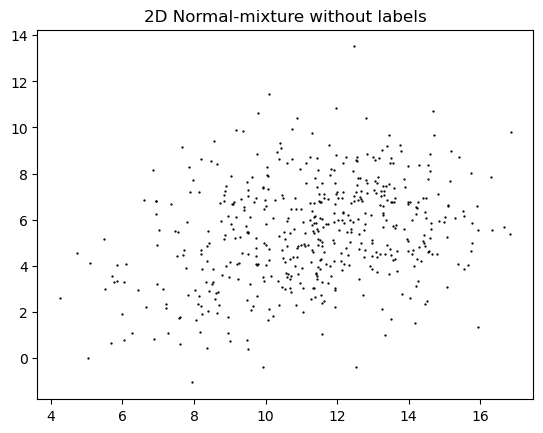

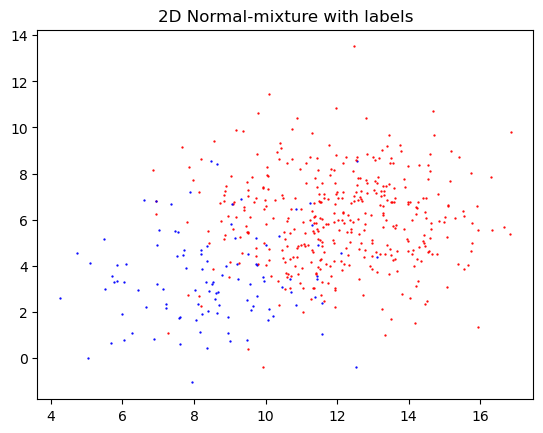

In [115]:
colors=['red','blue']
colors=['red','blue']
for n in range(len(mydata)):
    plt.scatter(mydata[n][0],mydata[n][1], color='black', s=0.4)
plt.title('2D Normal-mixture without labels')
plt.savefig('2D_gaussian-mixture_wo_labels.png')
plt.show()

for n in range(len(mydata)):
    plt.scatter(mydata[n][0],mydata[n][1], color=colors[mydata[n][2]], s=0.4)
plt.title('2D Normal-mixture with labels')
plt.savefig('2D_gaussian-mixture_w_labels.png')
plt.show()

### STAN Model

In [105]:
my_model = """
data {
 int <lower=0> N; // number of datapoints
 array[N,2] real y;  // there are 2 observables per datapoint
 real mumuA1, sigmamuA1, musigmaA1, sigmasigmaA1, 
      mumuB1, sigmamuB1, musigmaB1, sigmasigmaB1,
      mumuA2, sigmamuA2, musigmaA2, sigmasigmaA2, 
      mumuB2, sigmamuB2, musigmaB2, sigmasigmaB2; // hyperparameters for Normals that are priors for each parameter
 real t1, t2; // hyperparameter for the Dirichlet prior to the mixture coefficient pi0      
}

parameters {
  real muA1, muB1, muA2, muB2; 
  real<lower=0> sigmaA1, sigmaB1, sigmaA2, sigmaB2;
  real<lower=0, upper=1> pi0;
  simplex[2] theta;  
}

transformed parameters{
  ordered[2] muA;
  ordered[2] muB;

  //We need to know the relative order of both classes in each observable
  muA[1] = muA1;
  muA[2] = muA2;
  muB[1] = muB1;
  muB[2] = muB2;
}

model {
    vector[2] lp;
    muA1 ~ normal(mumuA1, sigmamuA1);
    sigmaA1 ~ normal(musigmaA1, sigmasigmaA1);
    muB1 ~ normal(mumuB1, sigmamuB1);
    sigmaB1 ~ normal(musigmaB1, sigmasigmaB1);    
    muA2 ~ normal(mumuA2, sigmamuA2);
    sigmaA2 ~ normal(musigmaA2, sigmasigmaA2);
    muB2 ~ normal(mumuB2, sigmamuB2);
    sigmaB2 ~ normal(musigmaB2, sigmasigmaB2);    
        
    theta ~ dirichlet([t1,t2]);
    
   for (n in 1:N) {
     lp[1] =   normal_lpdf(y[n,1] | muA1, sigmaA1)
             + normal_lpdf(y[n,2] | muB1, sigmaB1);
     lp[2] =   normal_lpdf(y[n,1] | muA2, sigmaA2)
             + normal_lpdf(y[n,2] | muB2, sigmaB2);
     target += log_mix(theta, lp);                        
     };
}
"""

### Infer

In [106]:
# Hyperparameters that rule the parameters priors
mumuA1 = 5
sigmamuA1 = 5
musigmaA1 = 3
sigmasigmaA1 = 3 

mumuB1 = 5
sigmamuB1 = 5
musigmaB1 = 3
sigmasigmaB1 = 3 

mumuA2 = 5
sigmamuA2 = 5
musigmaA2 = 3
sigmasigmaA2 = 3 

mumuB2 = 5
sigmamuB2 = 5
musigmaB2 = 3
sigmasigmaB2 = 3 

t1 = 1
t2 = 1

In [107]:
passed_data = [[x[0], x[1]] for x in mydata] # don't pass the class to which belongs each datapoint

In [108]:
data = {'N': N,
        'y': passed_data,
        'mumuA1': mumuA1,
        'sigmamuA1': sigmamuA1,
        'musigmaA1': musigmaA1,
        'sigmasigmaA1': sigmasigmaA1, 
        'mumuB1': mumuB1,
        'sigmamuB1': sigmamuB1,
        'musigmaB1': musigmaB1,
        'sigmasigmaB1': sigmasigmaB1,
        'mumuA2': mumuA2, 
        'sigmamuA2': sigmamuA2, 
        'musigmaA2': musigmaA2, 
        'sigmasigmaA2': sigmasigmaA2,
        'mumuB2': mumuB2,
        'sigmamuB2': sigmamuB2,
        'musigmaB2': musigmaB2,
        'sigmasigmaB2': sigmasigmaB2,
        't1': t1,
        't2': t2}

In [109]:
model = stan.build(my_model, data=data, random_seed=0);

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_trdf0c0s/model_53b65oip.stan', line 41, column 4: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    calculation.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    

In [110]:
fit = model.sample(num_chains=4, num_samples=1000, delta=0.8)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   3% (201/8000)
Sampling:   5% (401/8000)
Sampling:  19% (1501/8000)
Sampling:  29% (2300/8000)
Sampling:  38% (3000/8000)
Sampling:  46% (3700/8000)
Sampling:  48% (3800/8000)
Sampling:  62% (5000/8000)
Sampling:  76% (6100/8000)
Sampling:  90% (7200/8000)
Sampling:  91% (7300/8000)
Sampling:  92% (7400/8000)
Sampling:  94% (7500/8000)
Sampling:  95% (7600/8000)
Sampling:  96% (7700/8000)
Sampling:  98% (7800/8000)
Sampling:  99% (7900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_53b65oip_namespace::log_prob: muA is not a valid ordered vector. The element at 2 is 0.0604822, but should be greater than the previous element, 0.746532 (in '/tmp/httpstan_enmczp1j/model_53b65oip.stan', line 20, column 2 to column 17)
  Gradient evaluation took 0.000925 seconds
  1000 tra

In [111]:
df = fit.to_frame() 
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,muA1,muB1,muA2,...,sigmaB1,sigmaA2,sigmaB2,pi0,theta.1,theta.2,muA.1,muA.2,muB.1,muB.2
draws,,,,,,,,,,,,,,,,,,,,,
0,-2233.719438,0.874779,0.376018,3.0,7.0,0.0,2239.505807,8.514445,2.899893,11.918149,...,1.463429,2.208983,1.948335,0.583438,0.198029,0.801971,8.514445,11.918149,2.899893,6.052308
1,-2237.435770,0.835261,0.365144,4.0,23.0,0.0,2241.059098,8.217679,2.910878,11.951816,...,1.664022,2.020449,1.889918,0.657369,0.206927,0.793073,8.217679,11.951816,2.910878,5.701170
2,-2234.826644,0.919936,0.361472,4.0,15.0,0.0,2243.952753,8.885218,2.885773,12.041307,...,1.433054,2.132157,1.866612,0.063806,0.202993,0.797007,8.885218,12.041307,2.885773,6.104276
3,-3200.211992,0.666667,0.016606,1.0,3.0,1.0,3202.026413,1.604804,3.483996,1.650175,...,4.353213,1.988255,0.406271,0.521346,0.951851,0.048149,1.604804,1.650175,3.483996,3.489130
4,-2234.022412,0.978555,0.376018,4.0,15.0,0.0,2237.676897,7.675143,2.759240,11.714495,...,1.550123,2.149186,2.078188,0.128909,0.127670,0.872330,7.675143,11.714495,2.759240,5.743109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-2258.764395,0.999986,0.016606,10.0,1023.0,0.0,2261.802425,11.293241,5.279202,12.872848,...,2.190121,1.133452,0.885760,0.600947,0.872128,0.127872,11.293241,12.872848,5.279202,7.311896
3996,-2236.638115,0.798296,0.376018,3.0,15.0,0.0,2241.784622,8.466290,2.958809,12.045291,...,1.427581,2.052779,1.909685,0.947585,0.170113,0.829887,8.466290,12.045291,2.958809,5.796140
3997,-2239.837617,0.926300,0.365144,3.0,15.0,0.0,2247.185163,8.424072,2.723111,12.024864,...,1.305265,2.197484,1.884790,0.870295,0.171115,0.828885,8.424072,12.024864,2.723111,6.132471


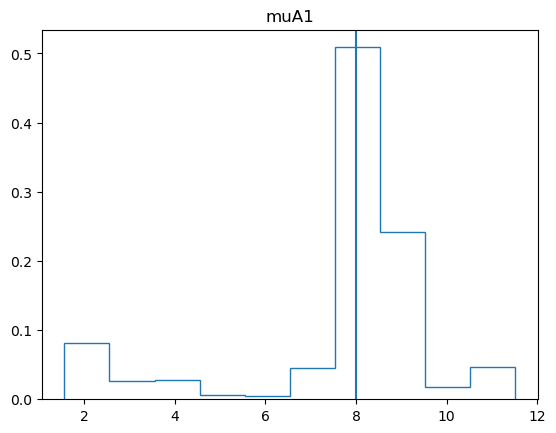

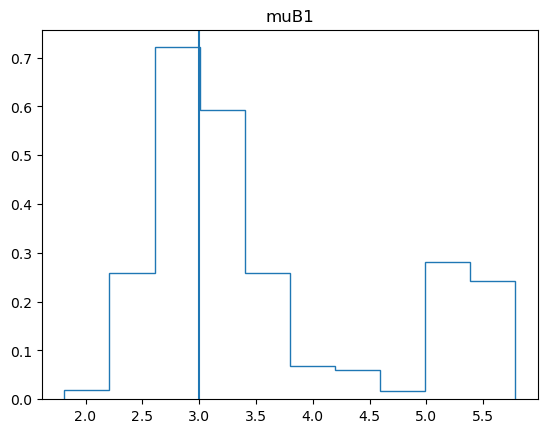

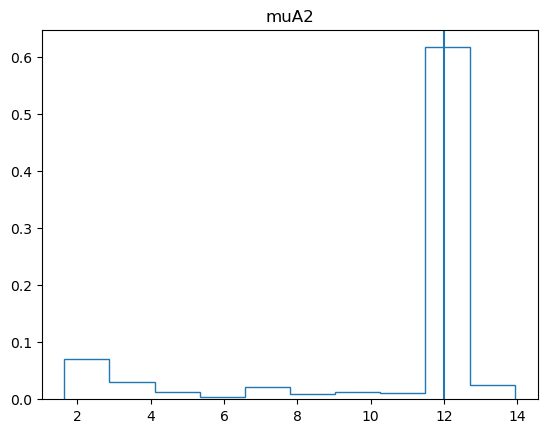

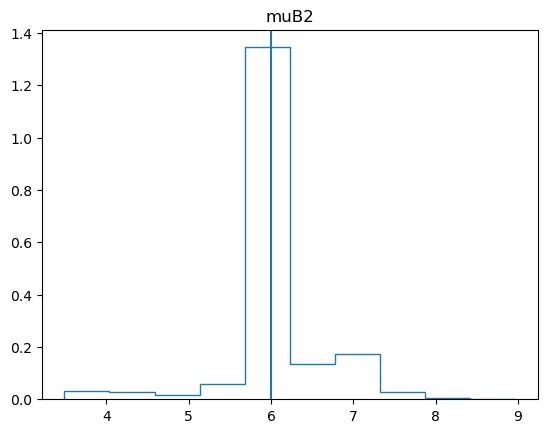

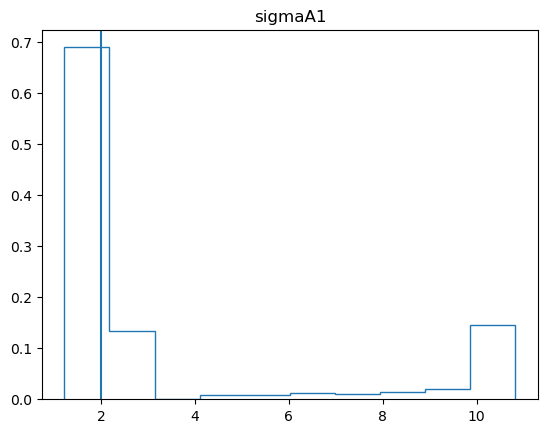

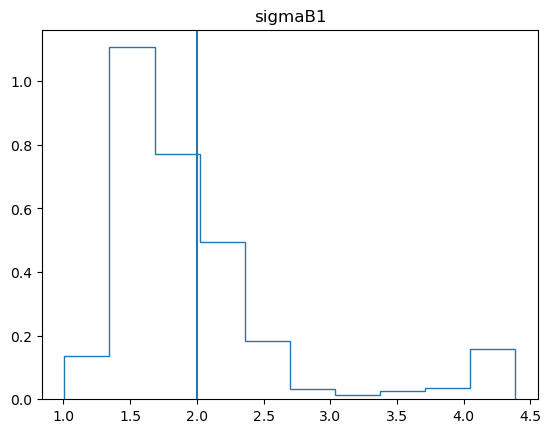

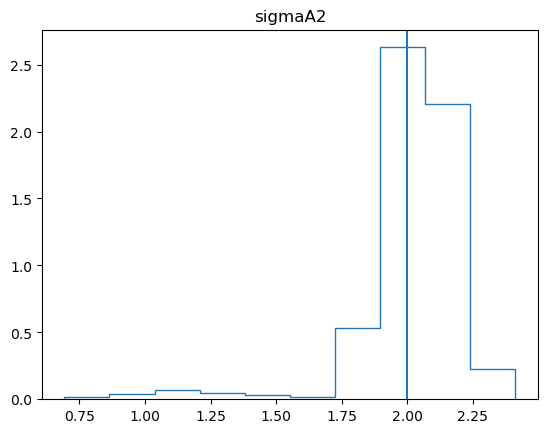

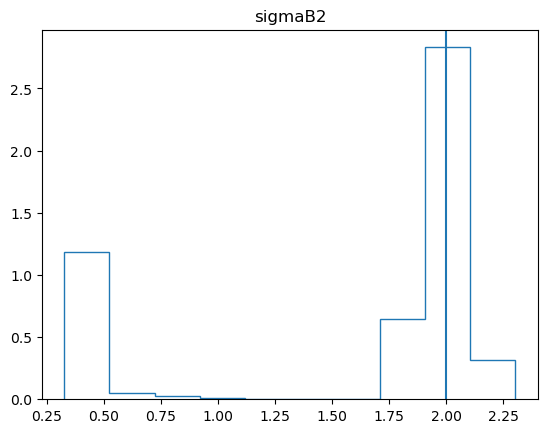

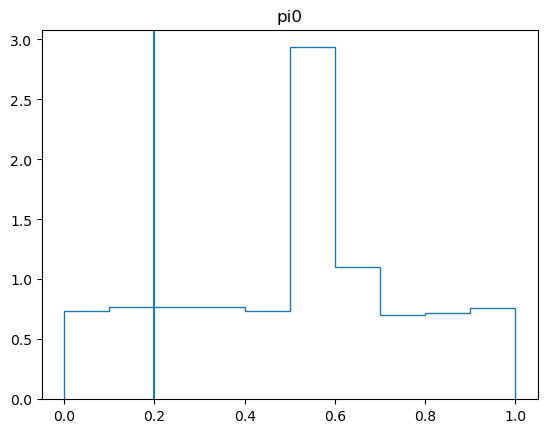

In [112]:
for varname in list(df)[7:16]:
    plt.hist(df[varname], histtype='step', density=1)
    plt.axvline(x= globals()[varname])
    plt.title(varname)
    plt.show()